In [16]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

# libraries
import numpy as np
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#### Reading Cancer data for the agegrp 60-69

In [17]:
import pickle
file = open("data_risk2_dummy","rb")
X_train = pickle.load(file)
y_train = pickle.load(file)
X_test = pickle.load(file)
y_test = pickle.load(file)
file.close()

In [18]:
X_train.head(2)

,menopaus_0,menopaus_1,agegrp_2,agegrp_3,agegrp_4,agegrp_5,agegrp_6,agegrp_7,agegrp_8,agegrp_9,...,nrelbc_1,nrelbc_2,brstproc_0,brstproc_1,lastmamm_0,lastmamm_1,surgmeno_0,surgmeno_1,hrt_0,hrt_1
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [19]:
X_test.head(2)

,menopaus_0,menopaus_1,agegrp_2,agegrp_3,agegrp_4,agegrp_5,agegrp_6,agegrp_7,agegrp_8,agegrp_9,...,nrelbc_1,nrelbc_2,brstproc_0,brstproc_1,lastmamm_0,lastmamm_1,surgmeno_0,surgmeno_1,hrt_0,hrt_1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


In [20]:
rfecol = ['menopaus_0', 'agegrp_2', 'agegrp_3', 'agegrp_4', 'agegrp_5',
       'agegrp_6', 'agegrp_7', 'agegrp_8', 'agegrp_9', 'agegrp_10',
       'density_1', 'density_4', 'race_2', 'race_3', 'race_4', 'race_5',
       'hispanic_0', 'hispanic_1', 'bmi_3', 'bmi_4', 'agefirst_1',
       'agefirst_2', 'nrelbc_0', 'nrelbc_2', 'lastmamm_1']
X_train=X_train[rfecol]
X_test=X_test[rfecol]

# Model Building on Cancer Data

## <span style="color:blue">Model 3 - Weighted SVM with SGD</span>

### Default Hyperparameters

Let's first fit a random forest model with default hyperparameters.

In [21]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score

def model_stats(X, y, y_pred, model):

    cm = confusion_matrix(y, y_pred)
    print("Confusion Matrix ->")
    print(cm)

    TP = cm[1,1] # true positive 
    TN = cm[0,0] # true negatives
    FP = cm[0,1] # false positives
    FN = cm[1,0] # false negatives
    
    print("Accuracy:",accuracy_score(y, y_pred))

    sensi = TP / float(TP+FN)
    speci = TN / float(TN+FP)
    
    # Let's see the sensitivity of our model
    print("Sensitivity:", sensi)

    # Let us calculate specificity
    print("Specificity:", speci)

    print("Average:", (sensi+speci)/2)
    
    # Let us calculate precision
    print("Precision",TP / float(TP+FP))
    print("MCC ", metrics.matthews_corrcoef(y, y_pred))
    print("F1 ", metrics.fbeta_score(y, y_pred, beta = 1))
    print("F2 ", metrics.fbeta_score(y, y_pred, beta = 2))
    print("F3 ", metrics.fbeta_score(y, y_pred, beta = 3))
    

In [22]:
# Importing random forest classifier from sklearn library
from sklearn.linear_model import SGDClassifier

In [23]:
sgd = SGDClassifier(random_state = 100)

# fit
sgd.fit(X_train,y_train)

SGDClassifier(random_state=100)

In [24]:
# Let's check the evaluation metrics of our default model

# Making predictions
y_pred_train_def = sgd.predict(X_train) # For train data
y_pred_test_def = sgd.predict(X_test) # For test data

#### Evaluating model on imbalanced train data with default parameters

In [25]:
# For train
model_stats(X_train, y_train, y_pred_train_def, sgd)

Confusion Matrix ->
[[109536      0]
 [  4293      0]]
Accuracy: 0.9622855335635031
Sensitivity: 0.0
Specificity: 1.0
Average: 0.5
Precision nan
MCC  0.0
F1  0.0
F2  0.0
F3  0.0


#### Evaluating model on imbalanced test data with default parameters

In [26]:
# For test
model_stats(X_test, y_test, y_pred_test_def, sgd)

Confusion Matrix ->
[[57930     0]
 [ 1571     0]]
Accuracy: 0.9735970824019764
Sensitivity: 0.0
Specificity: 1.0
Average: 0.5
Precision nan
MCC  0.0
F1  0.0
F2  0.0
F3  0.0


In [27]:
from sklearn.calibration import CalibratedClassifierCV
ccv = CalibratedClassifierCV(sgd, cv='prefit')
ccv.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(random_state=100),
                       cv='prefit')

In [28]:
# Predicting probability for roc_auc
def cal_roc(model, X, y):
    pred_probs = model.predict_proba(X)[:,1]
    print("ROC-AUC : {:2.2}".format(roc_auc_score(y, pred_probs)))

    # Plotting ROC curve
    fpr, tpr, thresholds = roc_curve(y, pred_probs, drop_intermediate = False )
    auc_score = roc_auc_score(y, pred_probs)
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

ROC-AUC : 0.64


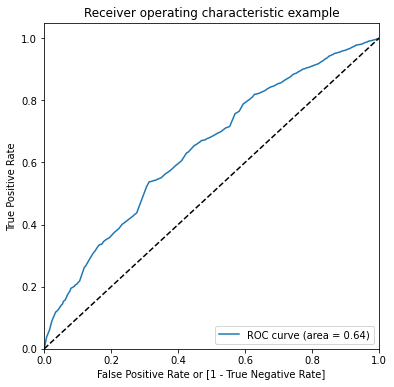

In [29]:
cal_roc(ccv, X_train, y_train)

ROC-AUC : 0.62


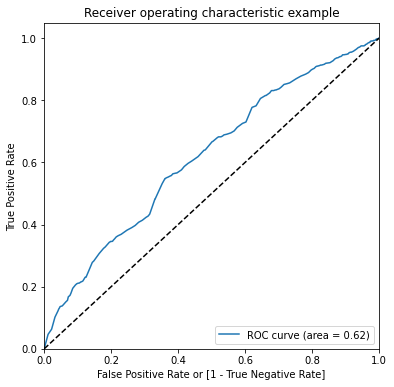

In [30]:
cal_roc(ccv, X_test, y_test)

### Hyperparameter Tuning : Grid Search to Find Optimal Hyperparameters


In [12]:
sgd = SGDClassifier(class_weight = 'balanced', random_state = 100)

# Fit the grid search to the data
sgd.fit(X_train, y_train)

SGDClassifier(class_weight='balanced', random_state=100)

In [13]:
# Let's check the evaluation metrics of our default model

# Making predictions
y_pred_train_def = sgd.predict(X_train) # For train data
y_pred_test_def = sgd.predict(X_test) # For test data

In [14]:
#### Evaluating model on imbalanced train data with default parameters

# For train
model_stats(X_train, y_train, y_pred_train_def, sgd)

Confusion Matrix ->
[[68451 41085]
 [ 1127  3166]]
Accuracy: 0.6291630428098288
Sensitivity: 0.7374796179827626
Specificity: 0.6249178352322524
Average: 0.6811987266075075
Precision 0.07154640573094394
MCC  0.14162714638491478
F1  0.13043836519446278
F2  0.2577210491184085
F3  0.3819612006563074


In [15]:
#### Evaluating model on imbalanced test data with default parameters

# For test
model_stats(X_test, y_test, y_pred_test_def, sgd)

Confusion Matrix ->
[[32037 25893]
 [  413  1158]]
Accuracy: 0.5578897833649855
Sensitivity: 0.7371101209420751
Specificity: 0.5530295183842568
Average: 0.6450698196631659
Precision 0.04280802927803039
MCC  0.09342173117802959
F1  0.08091677730417161
F2  0.1736913154342283
F3  0.2811361981063365


In [20]:
# We can now find the optimal hyperparameters using GridSearchCV.
from sklearn.model_selection import GridSearchCV,StratifiedKFold

# Create a cross validation scheme
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 100)

# Create the parameter grid based on the results of random search 
param_grid = {
    'loss': ['hinge','squared_hinge']
}

sgd = SGDClassifier(class_weight = 'balanced', random_state = 100)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = sgd, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best balanced accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

By default the loss is 'hinge'

In [21]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'penalty' : ['l1', 'l2', 'elasticnet'] 
}

sgd = SGDClassifier(class_weight = 'balanced', random_state = 100)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = sgd, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best balanced accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.1s finished


best balanced accuracy 0.6706656045697788
SGDClassifier(class_weight='balanced', penalty='l1', random_state=100)


In [23]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_iter' : [200, 400, 600, 800] 
}

sgd = SGDClassifier(class_weight = 'balanced', penalty='l1', random_state = 100)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = sgd, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best balanced accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.4s finished


best balanced accuracy 0.6706656045697788
SGDClassifier(class_weight='balanced', max_iter=200, penalty='l1',
              random_state=100)


In [24]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] 
}

sgd = SGDClassifier(class_weight = 'balanced', penalty='l1', max_iter=200, random_state = 100)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = sgd, param_grid = param_grid, scoring='balanced_accuracy',
                          cv = folds, n_jobs = -1,verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# printing the optimal accuracy score and hyperparameters
print("best balanced accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   11.2s finished


best balanced accuracy 0.678399114393754
SGDClassifier(alpha=0.001, class_weight='balanced', max_iter=200, penalty='l1',
              random_state=100)


In [25]:
### Model using best parameters obtained from grid search

sgd = SGDClassifier(class_weight = 'balanced', max_iter=200, penalty='l1', alpha=0.001, random_state = 100)

# Fit the grid search to the data
sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.001, class_weight='balanced', max_iter=200, penalty='l1',
              random_state=100)

In [26]:
#### Model evaluation on train data

# Predicting on test dataframe using predict
y_pred_train = sgd.predict(X_train)

model_stats(X_train, y_train, y_pred_train, sgd)

Confusion Matrix ->
[[70514 39022]
 [ 1220  3073]]
Accuracy: 0.6464697045568353
Sensitivity: 0.7158164453761938
Specificity: 0.6437518258837277
Average: 0.6797841356299608
Precision 0.07300154412638081
MCC  0.14189348777443297
F1  0.13249116150728638
F2  0.25925051040207875
F3  0.3806421245602735


In [27]:
sgd.coef_

array([[ 0.52109298,  0.05838336,  0.        ,  0.23636182,  0.4304753 ,
         0.41589788,  0.42179333,  0.48007129,  0.35756981,  0.14355987,
        -1.53638655, -0.42570599, -1.62836441, -0.6687879 , -1.85671172,
        -1.67425685,  1.12825632, -0.50543688, -0.52561655, -0.76292825,
        -0.52799604, -0.5346197 ,  0.37535767, -0.92516676, -1.1628054 ]])

In [28]:
# List of cols with their coefficients
val=sgd.coef_.reshape(-1)
coef = (pd.DataFrame(val, index=X_train.columns, columns = ['Coefficients'] )).reset_index()
coef = coef.rename(columns={'index':'Features'})
coef = coef.sort_values(by = 'Coefficients', ascending=False)
coef

,Features,Coefficients
16,hispanic_0,1.128256
0,menopaus_0,0.521093
7,agegrp_8,0.480071
4,agegrp_5,0.430475
6,agegrp_7,0.421793
5,agegrp_6,0.415898
22,nrelbc_0,0.375358
8,agegrp_9,0.357570
3,agegrp_4,0.236362
9,agegrp_10,0.143560


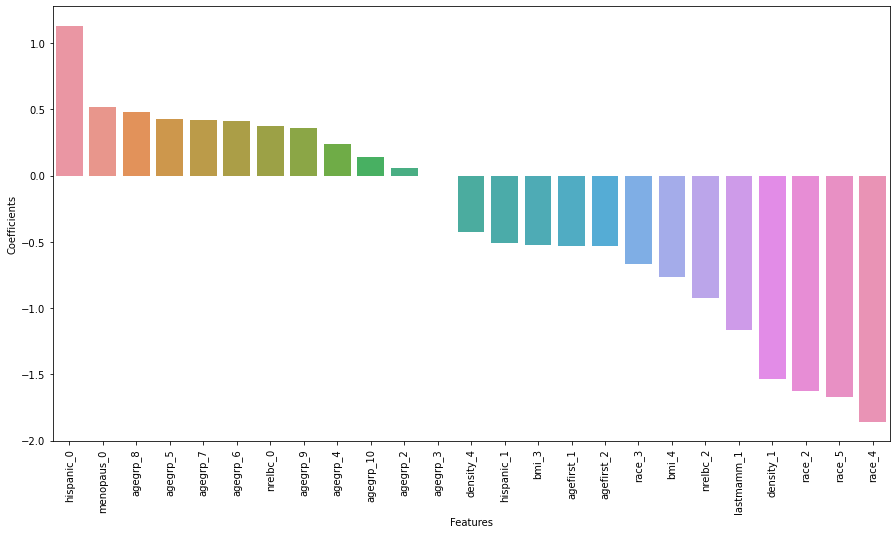

In [29]:
# Plotting important features against their coefficients
plt.figure(figsize=(15,8))
plt.subplot(111)
ax1 = sns.barplot(x = coef['Features'], y = coef['Coefficients'])
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90, fontsize=10)
#plt.ylabel('Coefficients')
plt.show()

#### Model evaluation on test data

In [30]:
# Predicting on test dataframe using predict

y_pred_test = sgd.predict(X_test)
model_stats(X_test, y_test, y_pred_test, sgd)

Confusion Matrix ->
[[33354 24576]
 [  422  1149]]
Accuracy: 0.5798726071830725
Sensitivity: 0.7313812858052197
Specificity: 0.5757638529259451
Average: 0.6535725693655824
Precision 0.04466472303206997
MCC  0.0994035061564158
F1  0.08418815943728018
F2  0.1794807710331469
F3  0.28822998193859123


In [31]:
from sklearn.calibration import CalibratedClassifierCV
ccv = CalibratedClassifierCV(sgd, cv='prefit')
ccv.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.001,
                                                    class_weight='balanced',
                                                    max_iter=200, penalty='l1',
                                                    random_state=100),
                       cv='prefit')

In [32]:
# Predicting probability for roc_auc
def cal_roc(model, X, y):
    pred_probs = model.predict_proba(X)[:,1]
    print("ROC-AUC : {:2.2}".format(roc_auc_score(y, pred_probs)))

    # Plotting ROC curve
    fpr, tpr, thresholds = roc_curve(y, pred_probs, drop_intermediate = False )
    auc_score = roc_auc_score(y, pred_probs)
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

ROC-AUC : 0.74


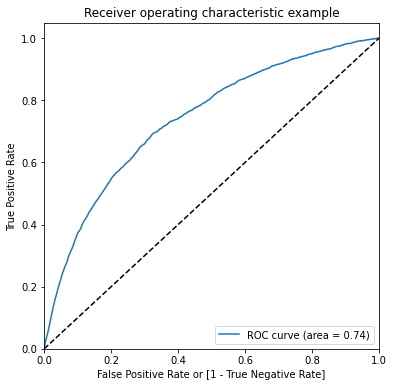

In [33]:
cal_roc(ccv, X_train, y_train)

ROC-AUC : 0.71


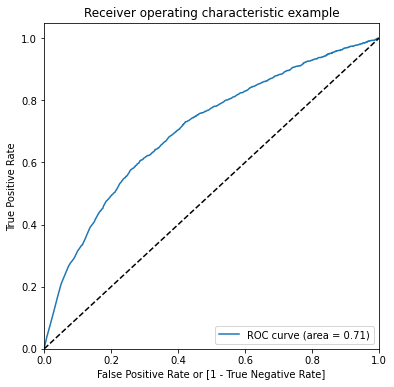

In [34]:
cal_roc(ccv, X_test, y_test)